In [38]:
from google.colab import drive

# Ruta para trabajar desde drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

gentrain = ImageDataGenerator(rescale=1. / 255., #indica que reescale cada canal con valor entre 0 y 1.
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

gentest = ImageDataGenerator(rescale=1./255.)

train = gentrain.flow_from_directory('/content/drive/MyDrive/Datasets/Caras/Train',
                batch_size=16,
                target_size=(180,180),
                class_mode='binary')

test = gentest.flow_from_directory('/content/drive/MyDrive/Datasets/Caras/Test',
                batch_size=16,
                target_size=(180,180),
                class_mode='binary')

Found 224 images belonging to 2 classes.
Found 224 images belonging to 2 classes.


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.api._v2.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

In [41]:
capas_convVGG19 =keras.applications.vgg19.VGG19(
    weights='imagenet',
    include_top= False,
    input_shape=(180,180,3)
)

capas_convVGG19.summary()

capas_convVGG19.trainable = True


for capas in capas_convVGG19.layers[:-4]:
  capas.trainable=False


capas_convVGG19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [50]:
inputs=keras.Input(shape=(180,180,3))
x = keras.applications.vgg19.preprocess_input(inputs)
x = capas_convVGG19(x)
x = Flatten()(x)
x = Dense(1024)(x)
x = Dense(512)(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

frvgg19 = keras.Model(inputs,outputs)
frvgg19.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem_6  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_6 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dense_18 (Dense)            (None, 1024)              1310

In [43]:
ruta_check= '/content/drive/MyDrive/Datasets/carasVGG19_checkpoints'
checkpoint = ModelCheckpoint(ruta_check, save_best_only=True)

frvgg19.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

earlycall=callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  mode = 'auto',
                                  restore_best_weights=True)

historial = frvgg19.fit(train,
                        epochs=30,
                        batch_size=16,
                        steps_per_epoch=14,
                        validation_data=test,
                        validation_steps=14,
                        callbacks=[checkpoint,earlycall],
                        verbose=1
                        )



Epoch 1/30
14/14 [==============================] - 289s 21s/step - loss: 13.6894 - accuracy: 0.5000 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 2/30
14/14 [==============================] - 280s 21s/step - loss: 0.9514 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/30
14/14 [==============================] - 271s 20s/step - loss: 0.7698 - accuracy: 0.5000 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 4/30
14/14 [==============================] - 272s 20s/step - loss: 0.6976 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 5/30
14/14 [==============================] - 242s 18s/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.5000


Este entrenamiento se uso como activación la función softmax, en la capa dnesa final (1 neurona)

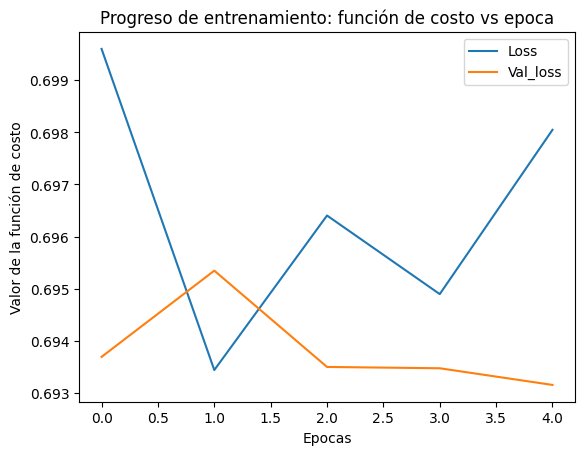

In [47]:
import matplotlib.pyplot as plt
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Progreso de entrenamiento: función de costo vs epoca')
plt.xlabel('Epocas')
plt.ylabel('Valor de la función de costo')
plt.legend(['Loss','Val_loss'])

In [51]:
ruta_check= '/content/drive/MyDrive/Datasets/carasVGG19_checkpoints'
checkpoint = ModelCheckpoint(ruta_check, save_best_only=True)

frvgg19.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['Accuracy'])

earlycall=callbacks.EarlyStopping(monitor='loss',
                                  patience=3,
                                  mode = 'auto',
                                  restore_best_weights=True)

historial = frvgg19.fit(train,
                        epochs=30,
                        batch_size=16,
                        steps_per_epoch=14,
                        validation_data=test,
                        validation_steps=14,
                        callbacks=[checkpoint,earlycall],
                        verbose=1
                        )


Epoch 1/30
14/14 [==============================] - 331s 25s/step - loss: 0.6981 - Accuracy: 0.4911 - val_loss: 0.6932 - val_Accuracy: 0.5000
Epoch 2/30
14/14 [==============================] - 280s 20s/step - loss: 0.6974 - Accuracy: 0.4375 - val_loss: 0.6932 - val_Accuracy: 0.5000
Epoch 3/30
14/14 [==============================] - 274s 20s/step - loss: 0.6949 - Accuracy: 0.4955 - val_loss: 0.6934 - val_Accuracy: 0.5000
Epoch 4/30
14/14 [==============================] - 278s 21s/step - loss: 0.6950 - Accuracy: 0.4821 - val_loss: 0.6932 - val_Accuracy: 0.5000
Epoch 5/30
14/14 [==============================] - 271s 20s/step - loss: 0.6941 - Accuracy: 0.5134 - val_loss: 0.6932 - val_Accuracy: 0.5000
Epoch 6/30
14/14 [==============================] - 273s 20s/step - loss: 0.6909 - Accuracy: 0.5357 - val_loss: 0.6974 - val_Accuracy: 0.5000
Epoch 7/30
14/14 [==============================] - 271s 20s/step - loss: 0.6985 - Accuracy: 0.4464 - val_loss: 0.6937 - val_Accuracy: 0.5000
Epoch 

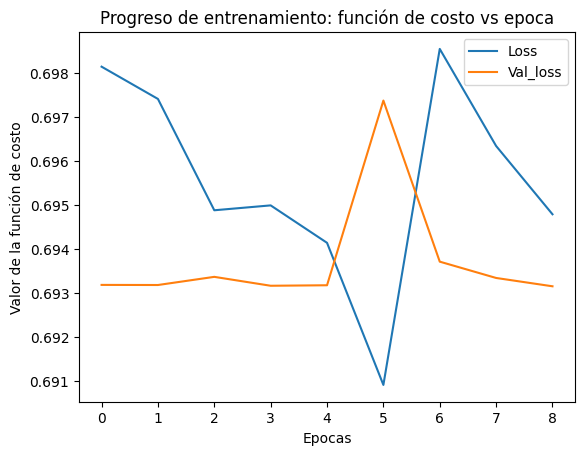

In [52]:
import matplotlib.pyplot as plt
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Progreso de entrenamiento: función de costo vs epoca')
plt.xlabel('Epocas')
plt.ylabel('Valor de la función de costo')
plt.legend(['Loss','Val_loss'])

In [53]:
ruta_check= '/content/drive/MyDrive/Datasets/carasVGG19_checkpoints'
checkpoint = ModelCheckpoint(ruta_check, save_best_only=True)

frvgg19.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['Accuracy'])

earlycall=callbacks.EarlyStopping(monitor='loss',
                                  patience=3,
                                  mode = 'auto',
                                  restore_best_weights=True)

historial = frvgg19.fit(train,
                        epochs=30,
                        batch_size=16,
                        steps_per_epoch=14,
                        validation_data=test,
                        validation_steps=14,
                        callbacks=[checkpoint],
                        verbose=1
                        )

Epoch 1/30
14/14 [==============================] - 283s 21s/step - loss: 0.6973 - Accuracy: 0.5000 - val_loss: 0.6963 - val_Accuracy: 0.5000
Epoch 2/30
14/14 [==============================] - 275s 20s/step - loss: 0.6954 - Accuracy: 0.5000 - val_loss: 0.6956 - val_Accuracy: 0.5000
Epoch 3/30
14/14 [==============================] - 276s 20s/step - loss: 0.6954 - Accuracy: 0.5000 - val_loss: 0.6950 - val_Accuracy: 0.5000
Epoch 4/30
14/14 [==============================] - 275s 20s/step - loss: 0.6953 - Accuracy: 0.5000 - val_loss: 0.6945 - val_Accuracy: 0.5000
Epoch 5/30
14/14 [==============================] - 275s 20s/step - loss: 0.6941 - Accuracy: 0.5000 - val_loss: 0.6942 - val_Accuracy: 0.5000
Epoch 6/30
14/14 [==============================] - 273s 20s/step - loss: 0.6951 - Accuracy: 0.5000 - val_loss: 0.6940 - val_Accuracy: 0.5000
Epoch 7/30
14/14 [==============================] - 274s 20s/step - loss: 0.6946 - Accuracy: 0.5000 - val_loss: 0.6938 - val_Accuracy: 0.5000
Epoch 

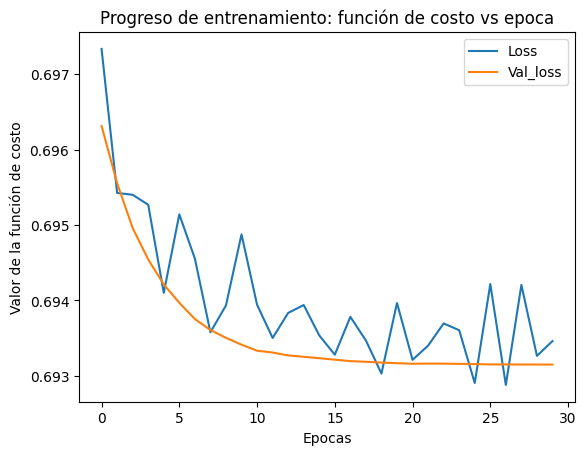

In [54]:
import matplotlib.pyplot as plt
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Progreso de entrenamiento: función de costo vs epoca')
plt.xlabel('Epocas')
plt.ylabel('Valor de la función de costo')
plt.legend(['Loss','Val_loss'])